#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

2022-01-27 16:34:13.662677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-27 16:34:13.662742: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
wiki = open('wiki_data.txt').read().split('\n')

In [43]:
cv = CountVectorizer(max_features=10000)
svd = TruncatedSVD(200)

X = cv.fit_transform(wiki)
X_svd = svd.fit_transform(X)

embeddings = svd.components_.T

id2word = cv.get_feature_names_out()
word2id = {word:i for i,word in enumerate(id2word)}

def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [6]:
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

In [7]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)  
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [8]:
# лемматизация тута здеся

def preprocess(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return tokens

In [9]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [10]:
filtered_vocab = []

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.append(word)

In [11]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
    
    
id2word = {i:word for word, i in word2id.items()}

In [12]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [13]:
vocab_size = len(id2word)

# вероятности посчитаны так
num_occur = sum(vocab[i] for i in filtered_vocab)
probs = [vocab[i] / num_occur for i in filtered_vocab]

### Skip-gram

In [14]:
def gen_batches_sg(sentences, window, use_ns, batch_size=1000): # здеся добавлен аргумент use_ns (типа если хочу negative sampling)
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    if use_ns == True: # а это отдельный if statement для негативного семплирования
                        X_target.append(word)
                        X_context.append(word2id[np.random.choice(filtered_vocab, p=probs)])
                        y.append(0)
                    else:
                        X_target.append(word)
                        X_context.append(np.random.randint(vocab_size))
                        y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [15]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

2022-01-27 16:41:00.852123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 16:41:00.852487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-27 16:41:00.852545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-27 16:41:00.852592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-27 16:41:00.852640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [16]:
model.fit(gen_batches_sg(sentences[:19000], window=12, use_ns=True),
          validation_data=gen_batches_sg(sentences[19000:],  window=12, use_ns=True),
          batch_size=10000,
          steps_per_epoch=1000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
1000/1000 [==============================] - 1015s 1s/step - loss: 0.6849 - accuracy: 0.5488 - val_loss: 0.6948 - val_accuracy: 0.5107
Epoch 2/2
1000/1000 [==============================] - 1056s 1s/step - loss: 0.6688 - accuracy: 0.5701 - val_loss: 0.6866 - val_accuracy: 0.5344


In [20]:
embeddings_sg = model.layers[2].get_weights()[0]

### CBOW

In [24]:
def gen_batches_cbow(sentences, window, use_ns, batch_size=1000): # здеся добавлен аргумент use_ns (типа если хочу negative sampling)
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                if use_ns == True: # а это отдельный if statement для негативного семплирования
                    X_target.append(word2id[np.random.choice(filtered_vocab, p=probs)])
                    X_context.append(context)
                    y.append(0)
                else:
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [25]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
model.fit(gen_batches_cbow(sentences[:19000], window=6, use_ns=True),
          validation_data=gen_batches_cbow(sentences[19000:],  window=6, use_ns=True),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 5412s 1s/step - loss: 0.5013 - accuracy: 0.7473 - val_loss: 0.4211 - val_accuracy: 0.8057
Epoch 2/2
5000/5000 [==============================] - 5924s 1s/step - loss: 0.3951 - accuracy: 0.8209 - val_loss: 0.3965 - val_accuracy: 0.8187


In [27]:
embeddings_cbow = model.layers[2].get_weights()[0]

### Тестирование

In [44]:
most_similar('больница', embeddings_sg)

['больница',
 'бронзовым',
 'берегах',
 'андреа',
 'лицом',
 'выполнении',
 'близких',
 'архитектора',
 'дивизию',
 'войн']

In [45]:
most_similar('больница', embeddings_cbow)

['больница',
 'ата',
 'предотвратить',
 'больнице',
 '1907',
 '1914',
 'был',
 'предположение',
 'практика',
 'бронзовым']

In [65]:
most_similar('небо', embeddings_sg)

['небо',
 'госпиталь',
 'иоанном',
 'игре',
 'знаком',
 'игрового',
 '36',
 '99',
 'души',
 'говорит']

In [66]:
most_similar('небо', embeddings_cbow)

['небо',
 'направлению',
 'восточном',
 'раз',
 'требуется',
 'имеющих',
 'продюсером',
 'говорит',
 'общественного',
 'составлял']

In [81]:
most_similar('общество', embeddings_sg)

['общество',
 'обществом',
 'орган',
 'переезжает',
 'dvd',
 'альбоме',
 'пожара',
 '1000',
 '1921',
 'обращается']

In [80]:
most_similar('общество', embeddings_cbow)

['общество',
 'племени',
 'принимают',
 'полюса',
 'рода',
 'ленинграде',
 'равно',
 'сил',
 'племён',
 'швейцарии']

Оказалось, что вообще все мимо. Только потом заметила, что окно пополам не поделила. Запомню на будущее.

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [28]:
import gensim

In [31]:
texts = [preprocess(text) for text in wiki]

In [37]:
%%time
w2v = gensim.models.Word2Vec(texts,
                            vector_size=100,
                            min_count=10,
                            max_vocab_size=None,
                            window=7,
                            epochs=10,
                            hs=1,
                            negative=0,
                            sample=0.0001,
                            cbow_mean=0)

CPU times: user 1min 8s, sys: 193 ms, total: 1min 8s
Wall time: 25.1 s


In [38]:
%%time
ft = gensim.models.FastText(texts,
                            vector_size=100,
                            min_count=10,
                            max_vocab_size=None,
                            window=7,
                            epochs=10,
                            hs=1,
                            negative=0,
                            sample=0.0001,
                            min_n=4,
                            max_n=8)

CPU times: user 6min 2s, sys: 366 ms, total: 6min 2s
Wall time: 2min 5s


# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

Выбранная модель -- ruwikiruscorpora_upos_cbow_300_10_2021

In [82]:
model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [86]:
data = pd.read_csv('labeled.csv')
data['norm_text'] = data.comment.apply(preprocess)

In [88]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6220

In [89]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [90]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [91]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [92]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)


In [93]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
# embedding слой возвращает последовательность векторов
# а нам нужно классифицировать сразу весь текст
# стандартный подход в этом случае - усреднить единичные вектора в 1 вектор текста
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
# к усредненному вектору мы уже применяем полносвязный слой, который вернет вероятность токсичности
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [94]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=10)

Epoch 1/10
428/428 [==============================] - 3s 7ms/step - loss: 0.6268 - accuracy: 0.6643 - val_loss: 0.5982 - val_accuracy: 0.6630
Epoch 2/10
428/428 [==============================] - 2s 5ms/step - loss: 0.5401 - accuracy: 0.6938 - val_loss: 0.5180 - val_accuracy: 0.7143
Epoch 3/10
428/428 [==============================] - 3s 6ms/step - loss: 0.4436 - accuracy: 0.8135 - val_loss: 0.4567 - val_accuracy: 0.8141
Epoch 4/10
428/428 [==============================] - 2s 5ms/step - loss: 0.3737 - accuracy: 0.8682 - val_loss: 0.4206 - val_accuracy: 0.8585
Epoch 5/10
428/428 [==============================] - 2s 5ms/step - loss: 0.3254 - accuracy: 0.8873 - val_loss: 0.4124 - val_accuracy: 0.8419
Epoch 6/10
428/428 [==============================] - 2s 5ms/step - loss: 0.2902 - accuracy: 0.9006 - val_loss: 0.4013 - val_accuracy: 0.8516
Epoch 7/10
428/428 [==============================] - 2s 5ms/step - loss: 0.2631 - accuracy: 0.9095 - val_loss: 0.3927 - val_accuracy: 0.8641
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


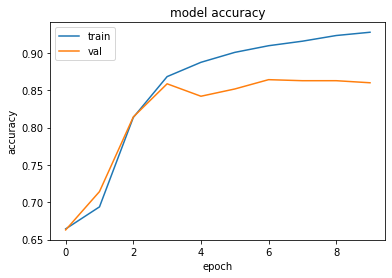

In [95]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()